# Deploy and use mWise Misinformation Detection<sup><small>TM</small></sup> from AWS Marketplace 


This sample notebook shows you how to deploy and use [**mWise Misinformation Detection**](https://machinewise.io/solutions/misinformation/) using Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make suggested changes first.

> **Note**: This notebook demoes usage of latest version of solution: 1.0.0

## Pre-requisites:
1. Jupyter interface - recommended are Amazon SageMaker Notebook Instance or Amazon SageMaker Studio
2. Ensure that IAM role used has **AmazonSageMakerFullAccess**
3. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        2. **aws-marketplace:Unsubscribe**
        3. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to **mWise Misinformation Detection**. If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

## Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Visualize output](#D.-Visualize-output)
   5. [Delete the endpoint](#F.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

## Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

## 1. Subscribe to the model package

To subscribe to the model package:
1. Open the **mWise Misinformation Detection** model package listing page: https://aws.amazon.com/marketplace/pp/prodview-cyf5zpuqocehs
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [1]:
model_package_arn = "<Please specify Model package ARN corresponding to your AWS region>"

In [3]:
import base64
import json
import io
import urllib3
import boto3
import pandas as pd

from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role

from IPython.display import display, HTML
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket = sagemaker_session.default_bucket()
sagemaker_runtime = boto3.client("runtime-sagemaker")

## 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [51]:
model_endpoint_name = "ooc-misinformation-detection"
real_time_inference_instance_type = "ml.t2.medium"
batch_transform_inference_instance_type = "ml.m5.xlarge"

In [98]:
# Local dev testing: DON'T RUN 
from sagemaker.local import LocalSagemakerRuntimeClient
sagemaker_runtime = LocalSagemakerRuntimeClient()
model_endpoint_name = "local-model-endpoint"

### A. Create an endpoint

In [ ]:
# create a deployable model from the model package.
model = ModelPackage(
    role=role, model_package_arn=model_package_arn, sagemaker_session=sagemaker_session
)

# Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_endpoint_name)

Once endpoint has been created, you would be able to perform real-time inference.

### B. Create input payload

**mWise Misinformation Detection** model is multimodal, since it takes image and image caption together as input. To prepare caption-image pair for inference, you'll need to prepare input data as multipart/form-data content-type. Let's first visualize example inputs.

Following image is from USA Today
Proper caption used was: "New England Patriots quarterback Tom Brady and Denver Broncos outside linebacker Von Miller have words during the first half at Sports Authority Field at Mile High"



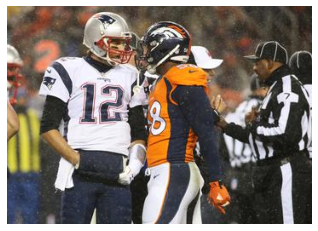

Consider also the following image repurposing, where we use that same caption with new image in an example of out-of-context misinformation


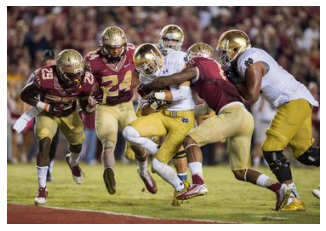

In [6]:
print("Following image is from USA Today")

caption = open("data/input/real-time/caption.txt", "r").read().strip()
print(f'Proper caption used was: "{caption}"\n')

proper_image = open('data/input/real-time/usa_today_proper_usage.jpeg', 'rb').read()
proper_image = Image.open(io.BytesIO(proper_image))

plt.imshow(proper_image)
plt.axis('off')
plt.show()

print("Consider also the following image repurposing, where we use that same caption with new image in an example of out-of-context misinformation")

ooc_image = open('data/input/real-time/guardian_out_of_context_usage.jpeg', 'rb').read()
ooc_image = Image.open(io.BytesIO(ooc_image))

plt.imshow(ooc_image)
plt.axis('off')
plt.show()

In [112]:
# load caption and image from data/input/real-time
caption = open("data/input/real-time/caption.txt", "r").read().strip()
proper_image = 'data/input/real-time/usa_today_proper_usage.jpeg'
ooc_image = 'data/input/real-time/guardian_out_of_context_usage.jpeg'

# multipart/form-data splits the input fields with random boundary, which we can control
form_boundary_string = "some_longer_unique_string"

# prepare proper payload
proper_payload, content_type_with_boundary = urllib3.encode_multipart_formdata({
    "caption": caption,
    "image": (proper_image.split('/')[-1], open(proper_image, "rb").read(), "image/jpeg"),
    "attention": "True"
}, boundary=form_boundary_string)

# prepare ooc payload
ooc_payload, content_type_with_boundary = urllib3.encode_multipart_formdata({
    "caption": caption,
    "image": (ooc_image.split('/')[-1], open(ooc_image, "rb").read(), "image/jpeg"),
    "attention": "True"
}, boundary=form_boundary_string)

### C. Perform real-time inference

In [113]:
expected_proper_response = sagemaker_runtime.invoke_endpoint(
    EndpointName=model_endpoint_name,
    ContentType=content_type_with_boundary,
    Accept='application/json',
    Body=proper_payload
)

# save for offline inspection
with open("data/output/real-time/proper.json", "w") as outfile:
    json.dump(json.loads(expected_proper_response['Body'].data), outfile)

expected_ooc_response = sagemaker_runtime.invoke_endpoint(
    EndpointName=model_endpoint_name,
    ContentType=content_type_with_boundary,
    Accept='application/json',
    Body=ooc_payload
)

# save for offline inspection
with open("data/output/real-time/ooc.json", "w") as outfile:
    json.dump(json.loads(expected_ooc_response['Body'].data), outfile)

### D. Visualize output

In [111]:
print(json.loads(expected_proper_response['Body'].data))

{'ModelVersion': '1.0.0', 'Labels': [{'Confidence': 0.9764931201934814, 'Name': 'Proper usage'}, {'Confidence': 0.023506879806518555, 'Name': 'Out-of-context usage'}], 'Attention': {'Caption': None, 'Image': None}}


As expected, probability of proper usage for proper use-case is higher for 1st image, and vice versa. Note that payload resembles AWS Rekognition payload for DetectLabels API.

### NOTE: If query parameter 'attention' was set to 'True', response payload will contain data that enables Explainability of attention between image and caption

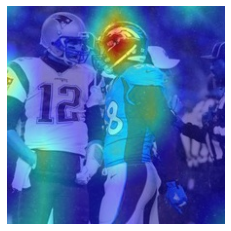

In [114]:
caption = json.loads(expected_proper_response['Body'].data)['Attention']['Caption']
html_caption = " ".join(['<span style="background-color:hsl(360,100%,' + str((1-float(c[1])) * 100) + '%)">' 
                         + str(c[0]) + ' </span>' for c in caption])
display(HTML(html_caption))

image = json.loads(expected_proper_response['Body'].data)['Attention']['Image']
image = base64.b64decode(image)
image = Image.open(io.BytesIO(image))
plt.imshow(image)
plt.axis('off')
plt.show()

### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [ ]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

## 3. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

Since AWS Marketplace SageMaker model products are restricted with network_isolation, it is not trivial to prepare images and captions as separate files for batch processing. One workaround is to base64 encode images and save to file together with respective caption.

Content type for batch processing should be CSV, with 2 columns without header:
- content string
- base64 image string

In [ ]:
# prepare captions and images from batch inpiut folder into input.csv file for batch processing
def process_line(line):
    with open(line['image'], "rb") as image_file:
        image_bytes = image_file.read()
        image_bytes_64 = base64.b64encode(image_bytes).decode("ascii")

    return image_bytes_64


def transform_test_data(test_data_file):
    test_data = pd.read_json(test_data_file, lines=True)
    test_data['image_bytes'] = test_data.apply(lambda x: process_line(x), axis=1)
    test_data = test_data[['caption', 'image_bytes']]
    test_data.to_csv("input.csv", header=False, index=False)
    
transform_test_data("test.jsonl")

In [ ]:
# upload the batch-transform job input CSV file to S3
transform_input_file = "data/input/batch/input.csv"
transform_input = sagemaker_session.upload_data(transform_input_file, key_prefix=model_endpoint_name)
print("Transform input uploaded to " + transform_input)

In [ ]:
# Run the batch-transform job
transformer = model.transformer(1, batch_transform_inference_instance_type, 
                                strategy='SingleRecord', accept='text/csv', assemble_with='Line')
transformer.transform(transform_input, content_type='text/csv', split_type='Line', join_source='Input')
transformer.wait()

In [ ]:
# output is available on following path
transformer.output_path

In [ ]:
# offline example can be found in data/output/batch/input.csv.out
print(open("data/output/batch/input.csv.out", "r").read())

## 4. Clean-up

### A. Delete the model

In [ ]:
model.delete_model()

### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

